In [1]:
import os
import numpy as np
from scipy.stats import kendalltau
from collections import defaultdict
from operator import itemgetter
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from geomloss import SamplesLoss
from sklearn.model_selection import KFold
import rouge
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from config_models import *
from datasets import *
from models import *
from preprocessing import *

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

torch.manual_seed(42)
# torch.set_default_tensor_type(torch.cuda.DoubleTensor)
cuda = torch.device('cuda:0')

[nltk_data] Downloading package punkt to /home/korunosk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATASET_ID_TRAIN = DATASET_IDS[0]
DATASET_ID_TEST = DATASET_IDS[1]
TOPIC_ID_TRAIN = TOPIC_IDS[DATASET_ID_TRAIN][0]
TOPIC_ID_TEST = TOPIC_IDS[DATASET_ID_TEST][0]
BASE_DATA_DIR = '/scratch/korunosk/data'
EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'BERT_sent')

-0.18377884834891503


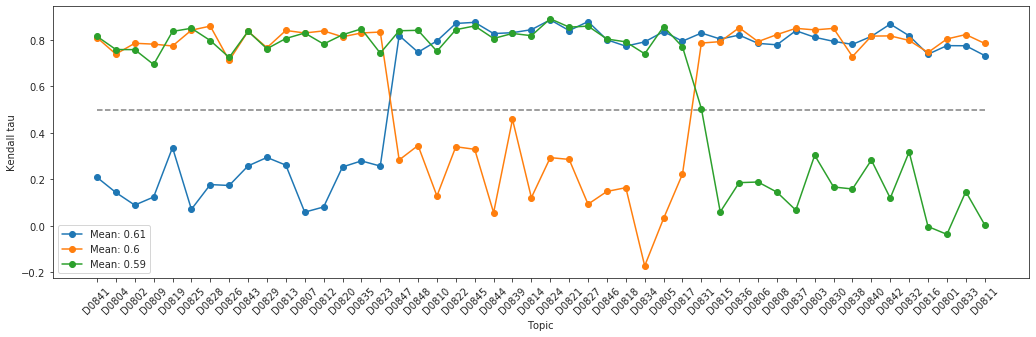

In [10]:
def execute():
    topic_ids = np.array(TOPIC_IDS[DATASET_ID_TRAIN])

    dataset = defaultdict(dict)

    for topic_id in topic_ids:
        topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
        document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)

        dataset[topic_id]['document_embs'] = np.array(document_embs)
        dataset[topic_id]['summary_embs'] = np.array(summary_embs)
        dataset[topic_id]['indices'] = np.array(indices)
        dataset[topic_id]['pyr_scores'] = np.array(pyr_scores)
        dataset[topic_id]['summ_ids'] = np.array(summ_ids)

    tuples_data = []

    for topic_id in topic_ids:
        tuples_data.extend(make_tuples_data_for_classification(EMBEDDINGS_DIR, DATASET_ID_TRAIN, topic_id))

    tuples_data = np.array(tuples_data)

    class TACDatasetClassification(Dataset):

        def __init__(self, data, transform):
            self.data = data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            topic_id = self.data[idx][0]

            i1 = dataset[topic_id]['indices'][int(self.data[idx][1])]
            i2 = dataset[topic_id]['indices'][int(self.data[idx][2])]

            d  = dataset[topic_id]['document_embs']
            s1 = dataset[topic_id]['summary_embs'][i1[0]:i1[1]]
            s2 = dataset[topic_id]['summary_embs'][i2[0]:i2[1]]
            y  = float(self.data[idx][3])

            return self.transform((d, s1, s2, y))

    class Normalize():

        def __call__(self, sample):
            d, s1, s2, y = sample

            d  = normalize(d,  axis=1)
            s1 = normalize(s1, axis=1)
            s2 = normalize(s2, axis=1)

            return d, s1, s2, y

    class ToTensor():

        def __call__(self, sample):
            d, s1, s2, y = sample

            d  = torch.tensor(d,  dtype=torch.float)
            s1 = torch.tensor(s1, dtype=torch.float)
            s2 = torch.tensor(s2, dtype=torch.float)
            y  = torch.tensor(y,  dtype=torch.float)

            return d, s1, s2, y

    class NeuralNetSinkhornPRModel(nn.Module):

        @staticmethod
        def load(fname, config):
            model = NeuralNetSinkhornPRModel(config)
            model.load_state_dict(torch.load(os.path.join(MODELS_DIR, fname)))
            model.eval()
            return model

        def save(self, fname):
            torch.save(self.state_dict(), os.path.join(MODELS_DIR, fname))

        def __init__(self, config):
            super(NeuralNetSinkhornPRModel, self).__init__()
            self.config = config
            self.sinkhorn = SamplesLoss(loss='sinkhorn', p=self.config['p'], blur=self.config['blur'], scaling=self.config['scaling'])
            self.layer = nn.Linear(self.config['D'], self.config['D'])
            self.sigm = nn.Sigmoid()

        def transform(self, x):
            return F.relu(self.layer(x))

        def predict(self, d, s):
            return self.sinkhorn(self.transform(d), self.transform(s))

        def forward(self, d, s1, s2):
            dist1 = self.predict(d, s1)
            dist2 = self.predict(d, s2)
            return self.sigm(self.config['scaling_factor'] * (dist2 - dist1))

    config = {
        'D': 768,
        'p': 2,
        'blur': .05,
        'scaling': .9,
        'scaling_factor': 1,
        'learning_rate': 1e-2,
        'batch_size': 100
    }

    transform = transforms.Compose([Normalize(), ToTensor()])

#     for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):

#         topic_ids_train = topic_ids[train_index]
#         topic_ids_test  = topic_ids[test_index]

#         tuples_train = tuples_data[np.isin(tuples_data[:,0], topic_ids_train)]
#         tuples_test  = tuples_data[np.isin(tuples_data[:,0], topic_ids_test)]

#         dataset_train = TACDatasetClassification(tuples_train, transform)
#         dataset_test  = TACDatasetClassification(tuples_test, transform)

#         neural_net_sinkhorn_pr_model = NeuralNetSinkhornPRModel(config).to(device=cuda)

#         criterion = nn.BCELoss()
#         optimizer = optim.Adam(neural_net_sinkhorn_pr_model.parameters(), lr=config['learning_rate'])

#         loss = []

#         data_loader_train = DataLoader(dataset_train, batch_size=config['batch_size'], shuffle=True, collate_fn=lambda x: x)

#         for i, batch in enumerate(data_loader_train):
#             optimizer.zero_grad()

#             L = 0.0

#             for sample in batch:
#                 d, s1, s2, y = sample

#                 y_hat = neural_net_sinkhorn_pr_model(d.to(device=cuda),
#                                                      s1.to(device=cuda),
#                                                      s2.to(device=cuda))

#                 L += criterion(y_hat, y.to(device=cuda))

#             L.backward()

#             optimizer.step()

#             loss.append(L.item())

#             # if i % 100 == 0:
#             print(f'Train Loss: {loss[-1]:.4f}')

#         neural_net_sinkhorn_pr_model.save(f'neural_net_sinkhorn_pr_model_cv_{model_num + 1}.pt')

#         fig = plt.figure(figsize=(10,5))
#         ax = fig.add_subplot(1,1,1)
#         plot_loss(ax, loss)
#         plt.show()

    def experiment(model, data):
        document_embs, summary_embs, indices, pyr_scores, summ_ids = data
        document_embs = torch.tensor(document_embs, dtype=torch.float).to(device=cuda)
        metric = lambda i: model.predict(document_embs,
                                         torch.tensor(summary_embs[i[0]:i[1]], dtype=torch.float).to(device=cuda))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    def execute_experiment(model, dataset, topic_ids, experiment):
        scores = []
        with torch.no_grad():
            for topic_id in topic_ids:
                scores.append(experiment(model, dataset[topic_id].values()))
        return np.array(scores)

    neural_net_sinkhorn_pr_models = [
        NeuralNetSinkhornPRModel.load('neural_net_sinkhorn_pr_model_cv_1.pt', config).to(device=cuda),
        NeuralNetSinkhornPRModel.load('neural_net_sinkhorn_pr_model_cv_2.pt', config).to(device=cuda),
        NeuralNetSinkhornPRModel.load('neural_net_sinkhorn_pr_model_cv_3.pt', config).to(device=cuda)
    ]

    neural_net_sinkhorn_pr_model_scores = [
        execute_experiment(neural_net_sinkhorn_pr_models[0], dataset, topic_ids, experiment),
        execute_experiment(neural_net_sinkhorn_pr_models[1], dataset, topic_ids, experiment),
        execute_experiment(neural_net_sinkhorn_pr_models[2], dataset, topic_ids, experiment)
    ]

    scores = []
    for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):
        topic_ids_test = topic_ids[test_index]
        scores.extend(execute_experiment(neural_net_sinkhorn_pr_models[model_num],
                                         dataset,
                                         topic_ids_test,
                                         experiment))

    print(-np.mean(scores))

    x = np.arange(len(dataset.keys()))
    fig = plt.figure(figsize=(17.5,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, -neural_net_sinkhorn_pr_model_scores[0], '-o', label=f'Mean: {-np.mean(neural_net_sinkhorn_pr_model_scores[0]):.2}')
    ax.plot(x, -neural_net_sinkhorn_pr_model_scores[1], '-o', label=f'Mean: {-np.mean(neural_net_sinkhorn_pr_model_scores[1]):.2}')
    ax.plot(x, -neural_net_sinkhorn_pr_model_scores[2], '-o', label=f'Mean: {-np.mean(neural_net_sinkhorn_pr_model_scores[2]):.2}')
    ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
    ax.set_xticks(x)
    ax.set_xticklabels(dataset.keys(), rotation=45)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Kendall tau')
    ax.legend(loc='best')
    plt.show()

execute()

0.25007576695224404


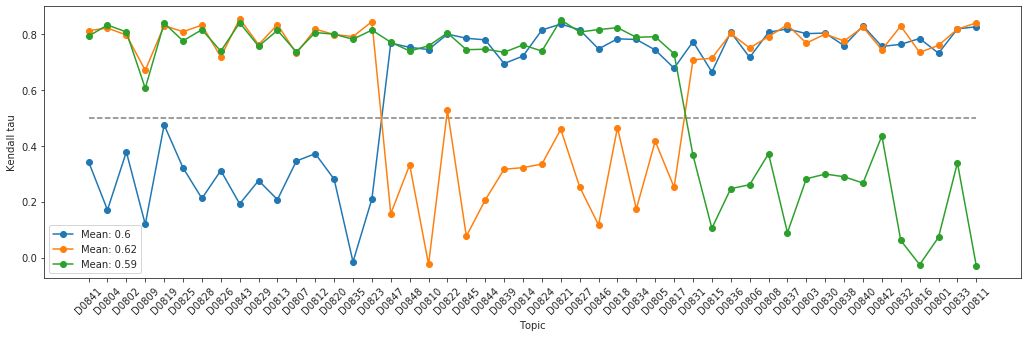

In [11]:
def execute():
    def make(shape, values, indices):
        ret = []
        for i in indices:
            t = i[1] - i[0]
            target = np.zeros(shape=shape)
            target[:t] = values[i[0]:i[1]]
            ret.extend(target.tolist())
        return ret

    M = 20
    N = 768

    topic_ids = np.array(TOPIC_IDS[DATASET_ID_TRAIN])

    dataset = defaultdict(dict)

    for topic_id in topic_ids:
        topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
        document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)

        dataset[topic_id]['document_embs'] = np.array(document_embs).mean(axis=0, keepdims=True).repeat(M, axis=0)
        dataset[topic_id]['summary_embs'] = np.array(make((M,N), summary_embs, indices))
        dataset[topic_id]['masks'] = np.array(make((M,1), np.ones(len(summary_embs)).reshape(-1,1), indices))
        dataset[topic_id]['indices'] = np.array([[i, i+1] for i in range(len(indices))]) * M
        dataset[topic_id]['pyr_scores'] = np.array(pyr_scores)
        dataset[topic_id]['summ_ids'] = np.array(summ_ids)

    tuples_data = []

    for topic_id in topic_ids:
        tuples_data.extend(make_tuples_data_for_classification(EMBEDDINGS_DIR, DATASET_ID_TRAIN, topic_id))

    tuples_data = np.array(tuples_data)

    class TACDatasetClassification(Dataset):

        def __init__(self, data, transform):
            self.data = data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            topic_id = self.data[idx][0]

            i1 = dataset[topic_id]['indices'][int(self.data[idx][1])]
            i2 = dataset[topic_id]['indices'][int(self.data[idx][2])]

            d  = dataset[topic_id]['document_embs']
            s1 = dataset[topic_id]['summary_embs'][i1[0]:i1[1]]
            s2 = dataset[topic_id]['summary_embs'][i2[0]:i2[1]]
            m1 = dataset[topic_id]['masks'][i1[0]:i1[1]]
            m2 = dataset[topic_id]['masks'][i2[0]:i2[1]]
            y  = float(self.data[idx][3])

            return self.transform((d, s1, s2, m1, m2, y))

    class ToTensor():
        def __call__(self, sample):
            d, s1, s2, m1, m2, y = sample

            d  = torch.tensor(d,  dtype=torch.float)
            s1 = torch.tensor(s1, dtype=torch.float)
            s2 = torch.tensor(s2, dtype=torch.float)
            m1 = torch.tensor(m1, dtype=torch.bool)
            m2 = torch.tensor(m2, dtype=torch.bool)
            y  = torch.tensor(y,  dtype=torch.float)

            return d, s1, s2, m1, m2, y

    class NeuralNetScoringPRModel(nn.Module):

        @staticmethod
        def load(fname, config):
            model = NeuralNetScoringPRModel(config)
            model.load_state_dict(torch.load(os.path.join(MODELS_DIR, fname)))
            model.eval()
            return model

        def save(self, fname):
            torch.save(self.state_dict(), os.path.join(MODELS_DIR, fname))

        def __init__(self, config):
            super(NeuralNetScoringPRModel, self).__init__()
            self.config = config
            self.layer1 = nn.Linear(self.config['D'], self.config['D'])
            self.layer2 = nn.Linear(self.config['H'], 1)
            self.sigm = nn.Sigmoid()

        def transform(self, x):
            return F.relu(self.layer1(x))

        def predict(self, d, s, m):
            x = torch.cat((self.transform(d), self.transform(s)), axis=2)
            z = self.layer2(x)
            return torch.stack([ torch.sum(z[i].masked_select(m[i])) for i in range(z.shape[0]) ])

        def forward(self, d, s1, s2, m1, m2):
            score1 = self.predict(d, s1, m1)
            score2 = self.predict(d, s2, m2)
            return self.sigm(self.config['scaling_factor'] * (score1 - score2))

    config = {
        'D': 768,
        'H': 1536,
        'scaling_factor': 1,
        'learning_rate': 1e-4,
        'batch_size': 100
    }

    transform = transforms.Compose([ToTensor()])

#     for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):

#         topic_ids_train = topic_ids[train_index]
#         topic_ids_test  = topic_ids[test_index]

#         tuples_train = tuples_data[np.isin(tuples_data[:,0], topic_ids_train)]
#         tuples_test  = tuples_data[np.isin(tuples_data[:,0], topic_ids_test)]

#         dataset_train = TACDatasetClassification(tuples_train, transform)
#         dataset_test  = TACDatasetClassification(tuples_test, transform)

#         neural_net_scoring_pr_model = NeuralNetScoringPRModel(config).to(device=cuda)

#         criterion = nn.BCELoss()
#         optimizer = optim.Adam(neural_net_scoring_pr_model.parameters(), lr=config['learning_rate'])

#         loss = []

#         data_loader_train = DataLoader(dataset_train, batch_size=config['batch_size'], num_workers=24, shuffle=True)

#         for i, batch in enumerate(data_loader_train):            
#             optimizer.zero_grad()

#             d, s1, s2, m1, m2, y = batch

#             y_hat = neural_net_scoring_pr_model(d.to(device=cuda),
#                                                 s1.to(device=cuda),
#                                                 s2.to(device=cuda),
#                                                 m1.to(device=cuda),
#                                                 m2.to(device=cuda))
#             y_hat = y_hat.squeeze()

#             L = criterion(y_hat, y.to(device=cuda))

#             L.backward()

#             optimizer.step()

#             loss.append(L.item())

#             if i % 100 == 0:
#                 print(f'Train Loss: {loss[-1]:.4f}')

#         neural_net_scoring_pr_model.save(f'neural_net_scoring_pr_model_cv_{model_num + 1}.pt')

#         fig = plt.figure(figsize=(10,5))
#         ax = fig.add_subplot(1,1,1)
#         plot_loss(ax, loss)
#         plt.show()

    def experiment(model, data):
        document_embs, summary_embs, masks, indices, pyr_scores, summ_ids = data
        document_embs = torch.tensor(document_embs, dtype=torch.float).unsqueeze(0).to(device=cuda)
        metric = lambda i: model.predict(document_embs,
                                         torch.tensor(summary_embs[i[0]:i[1]], dtype=torch.float).unsqueeze(0).to(device=cuda),
                                         torch.tensor(masks[i[0]:i[1]], dtype=torch.bool).to(device=cuda))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    def execute_experiment(model, dataset, topic_ids, experiment):
        scores = []
        with torch.no_grad():
            for topic_id in topic_ids:
                scores.append(experiment(model, dataset[topic_id].values()))
        return np.array(scores)

    neural_net_scoring_pr_models = [
        NeuralNetScoringPRModel.load('neural_net_scoring_pr_model_cv_1.pt', config).to(device=cuda),
        NeuralNetScoringPRModel.load('neural_net_scoring_pr_model_cv_2.pt', config).to(device=cuda),
        NeuralNetScoringPRModel.load('neural_net_scoring_pr_model_cv_3.pt', config).to(device=cuda)
    ]

    neural_net_scoring_pr_model_scores = [
        execute_experiment(neural_net_scoring_pr_models[0], dataset, topic_ids, experiment),
        execute_experiment(neural_net_scoring_pr_models[1], dataset, topic_ids, experiment),
        execute_experiment(neural_net_scoring_pr_models[2], dataset, topic_ids, experiment)
    ]

    scores = []
    for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):
        topic_ids_test = topic_ids[test_index]
        scores.extend(execute_experiment(neural_net_scoring_pr_models[model_num],
                                         dataset,
                                         topic_ids_test,
                                         experiment))

    print(np.mean(scores))

    x = np.arange(len(dataset.keys()))
    fig = plt.figure(figsize=(17.5,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, neural_net_scoring_pr_model_scores[0], '-o', label=f'Mean: {np.mean(neural_net_scoring_pr_model_scores[0]):.2}')
    ax.plot(x, neural_net_scoring_pr_model_scores[1], '-o', label=f'Mean: {np.mean(neural_net_scoring_pr_model_scores[1]):.2}')
    ax.plot(x, neural_net_scoring_pr_model_scores[2], '-o', label=f'Mean: {np.mean(neural_net_scoring_pr_model_scores[2]):.2}')
    ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
    ax.set_xticks(x)
    ax.set_xticklabels(dataset.keys(), rotation=45)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Kendall tau')
    ax.legend(loc='best')
    plt.show()

execute()

-0.00961615935777495


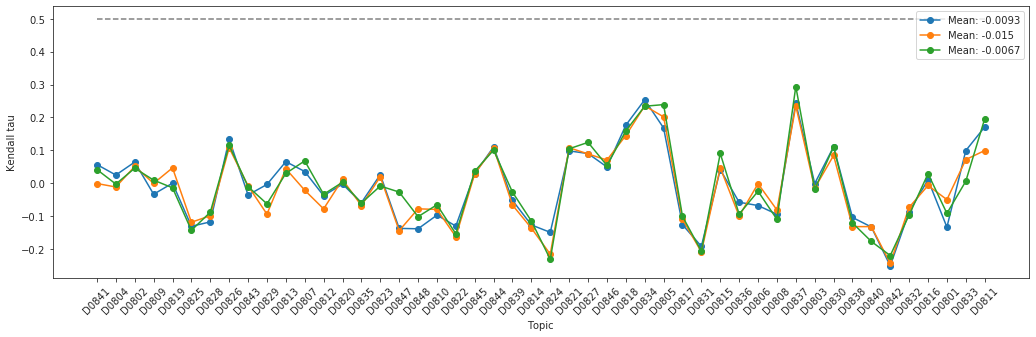

In [12]:
def execute():
    evaluator = rouge.Rouge(metrics=['rouge-n'],
                            max_n=2,
                            length_limit=100,
                            length_limit_type='words')

    topic_ids = np.array(TOPIC_IDS[DATASET_ID_TRAIN])

    dataset = defaultdict(dict)

    for topic_id in topic_ids:
        topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
        document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)

        dataset[topic_id]['document_embs'] = np.array(document_embs)
        dataset[topic_id]['summary_embs'] = np.array(summary_embs)
        dataset[topic_id]['indices'] = np.array(indices)
        dataset[topic_id]['pyr_scores'] = np.array(pyr_scores)
        dataset[topic_id]['summ_ids'] = np.array(summ_ids)

    def make_tuples_data_for_regression(base_data_dir, dataset_id, topic_id):
        topic = load_data(base_data_dir, dataset_id, encoded=False)[topic_id]
        documents, summaries, indices, _, _ = extract(topic)
        reference_summaries = summaries[indices[-4][0]:indices[-1][1]]

        data = []
        n = len(documents) 
        for i in range(n):
            y = evaluator.get_scores(documents[i], reference_summaries)['rouge-2']['r']
            data.append((topic_id, i, y))

        return data

    tuples_data = []

    for topic_id in topic_ids:
        tuples_data.extend(make_tuples_data_for_regression(BASE_DATA_DIR, DATASET_ID_TRAIN, topic_id))

    tuples_data = np.array(tuples_data)

    class TACDatasetRegression(Dataset):

        def __init__(self, data, transform):
            self.data = data
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            topic_id = self.data[idx][0]

            i = int(self.data[idx][1])

            s = dataset[topic_id]['document_embs'][i]
            y = float(self.data[idx][2])

            return self.transform((s, y))

    class ToTensor():

        def __call__(self, sample):
            s, y = sample

            s = torch.tensor(s, dtype=torch.float)
            y = torch.tensor(y, dtype=torch.float)

            return s, y

    config = {
        'D': 768,
        'p': 2,
        'blur': .05,
        'scaling': .9,
        'learning_rate': 1e-2,
        'batch_size': 100
    }

    class NeuralNetRougeRegModel(nn.Module):

        @staticmethod
        def load(fname, config):
            model = NeuralNetRougeRegModel(config)
            model.load_state_dict(torch.load(os.path.join(MODELS_DIR, fname)))
            model.eval()
            return model

        def save(self, fname):
            torch.save(self.state_dict(), os.path.join(MODELS_DIR, fname))

        def __init__(self, config):
            super(NeuralNetRougeRegModel, self).__init__()
            self.config = config
            self.sinkhorn = SamplesLoss(loss='sinkhorn', p=self.config['p'], blur=self.config['blur'], scaling=self.config['scaling'])
            self.layer = nn.Linear(self.config['D'], self.config['D'])

        def transform(self, x):
            return F.relu(self.layer(x))

        def predict(self, d, s):
            return self.sinkhorn(self.transform(d), self.transform(s))

        def forward(self, sent):
            return torch.norm(self.transform(sent), p=2, dim=1)

    transform = transforms.Compose([ToTensor()])

#     for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):

#         topic_ids_train = topic_ids[train_index]
#         topic_ids_test  = topic_ids[test_index]

#         tuples_train = tuples_data[np.isin(tuples_data[:,0], topic_ids_train)]
#         tuples_test  = tuples_data[np.isin(tuples_data[:,0], topic_ids_test)]

#         dataset_train = TACDatasetRegression(tuples_train, transform)
#         dataset_test  = TACDatasetRegression(tuples_test, transform)

#         neural_net_rouge_reg_model = NeuralNetRougeRegModel(config).to(device=cuda)

#         criterion = nn.MSELoss()
#         optimizer = optim.SGD(neural_net_rouge_reg_model.parameters(), lr=config['learning_rate'])

#         loss = []

#         data_loader_train = DataLoader(dataset_train, batch_size=config['batch_size'], num_workers=24, shuffle=True)

#         for i, batch in enumerate(data_loader_train):            
#             optimizer.zero_grad()

#             s, y = batch

#             y_hat = neural_net_rouge_reg_model(s.to(device=cuda))
#             y = -torch.log(y + 0.00001).to(device=cuda)

#             L = criterion(y_hat, y)

#             L.backward()

#             optimizer.step()

#             loss.append(L.item())

#             print(f'Train Loss: {loss[-1]:.4f}')

#         neural_net_rouge_reg_model.save(f'neural_net_rouge_reg_model_cv_{model_num + 1}.pt')

#         fig = plt.figure(figsize=(10,5))
#         ax = fig.add_subplot(1,1,1)
#         plot_loss(ax, loss)
#         plt.show()

    def experiment(model, data):
        document_embs, summary_embs, indices, pyr_scores, summ_ids = data
        document_embs = torch.tensor(document_embs, dtype=torch.float).to(device=cuda)
        metric = lambda i: model.predict(document_embs,
                                         torch.tensor(summary_embs[i[0]:i[1]], dtype=torch.float).to(device=cuda))
        return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

    def execute_experiment(model, dataset, topic_ids, experiment):
        scores = []
        with torch.no_grad():
            for topic_id in topic_ids:
                scores.append(experiment(model, dataset[topic_id].values()))
        return np.array(scores)

    neural_net_rouge_reg_models = [
        NeuralNetRougeRegModel.load('neural_net_rouge_reg_model_cv_1.pt', config).to(device=cuda),
        NeuralNetRougeRegModel.load('neural_net_rouge_reg_model_cv_2.pt', config).to(device=cuda),
        NeuralNetRougeRegModel.load('neural_net_rouge_reg_model_cv_3.pt', config).to(device=cuda)
    ]

    neural_net_rouge_reg_model_scores = [
        execute_experiment(neural_net_rouge_reg_models[0], dataset, topic_ids, experiment),
        execute_experiment(neural_net_rouge_reg_models[1], dataset, topic_ids, experiment),
        execute_experiment(neural_net_rouge_reg_models[2], dataset, topic_ids, experiment)
    ]

    scores = []
    for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):
        topic_ids_test = topic_ids[test_index]
        scores.extend(execute_experiment(neural_net_rouge_reg_models[model_num],
                                         dataset,
                                         topic_ids_test,
                                         experiment))

    print(np.mean(scores))

    x = np.arange(len(dataset.keys()))
    fig = plt.figure(figsize=(17.5,5))
    ax = fig.add_subplot(1,1,1)
    ax.plot(x, neural_net_rouge_reg_model_scores[0], '-o', label=f'Mean: {np.mean(neural_net_rouge_reg_model_scores[0]):.2}')
    ax.plot(x, neural_net_rouge_reg_model_scores[1], '-o', label=f'Mean: {np.mean(neural_net_rouge_reg_model_scores[1]):.2}')
    ax.plot(x, neural_net_rouge_reg_model_scores[2], '-o', label=f'Mean: {np.mean(neural_net_rouge_reg_model_scores[2]):.2}')
    ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
    ax.set_xticks(x)
    ax.set_xticklabels(dataset.keys(), rotation=45)
    ax.set_xlabel('Topic')
    ax.set_ylabel('Kendall tau')
    ax.legend(loc='best')
    plt.show()

execute()